In [19]:
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
import torchvision
import torch.utils.data as data_utils
import numpy as np

torch.manual_seed(1)

In [20]:
class Discriminator(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 4, 2, 1, bias=False)
        self.norm1 = nn.BatchNorm2d(16)
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)

        # 16 x 14 x 14
        self.conv2 = nn.Conv2d(16, 32, 7, 2, 0, bias=False)
        self.norm2 = nn.BatchNorm2d(32)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)


        # 32 x 4 x 4
        self.conv3 = nn.Conv2d(32, 1, 4, 2, 0, bias=False)
        self.sigmoid = nn.Sigmoid()

        # Linear
        self.flatten = nn.Flatten()
        self.out = nn.Linear(32*4*4, 1)


    def forward(self, x):
        #print("Forward pass")
        #print(x.shape)
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)

        #print(x.shape)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        # print(f'conv shape {x.shape}')
        #print(x.shape)

        # x = self.conv3(x)
        # print(f'conv shape {x.shape}')
        x = self.flatten(x)
        # print(f'flat shape {x.shape}')

        return self.out(x)


kernel_size = 5  # <-- Kernel size
conv_stride = 1  # <-- Stride
conv_pad = 2  # <-- Padding
n_z = 20
ngf = 64
class Generator(nn.Module):
    def __init__(self, n_z, ngf, ndf):
        super(Generator, self).__init__()

        self.network = nn.Sequential(
            # in: n_z

            nn.ConvTranspose2d(n_z, ngf * 2, 7, 1, 0, bias=False),
            # out: (ngf*2) x 7 x 7
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf * 1, 4, 2, 1, bias=False),
            # out: (ngf) x 14 x 14
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, 1, 4, 2, 1),
            # out: 1 x 28 x 28
            nn.BatchNorm2d(1),
            nn.ReLU(True),
        )

    def forward(self, x):
        return self.network(x)

'''class Generator(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(Generator, self).__init__()

        self.network = nn.Sequential(
            # in: 20

            nn.ConvTranspose2d(n_z, ngf * 2, 7, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # (ngf*2) x 7 x 7

            nn.ConvTranspose2d(ngf * 2, ngf * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # (ngf) x 14 x 14

            nn.ConvTranspose2d(ngf, 1, 4, 2, 1),
        )

    def forward(self, x):
        return self.network(x)'''


model_G = Generator(n_z, ngf, 28 * 28)
model_D = Discriminator(28 * 28, 256)

In [21]:
'''optimizer_G = optim.RMSprop(model_G.parameters(), lr=0.002)
optimizer_D = optim.RMSprop(model_D.parameters(), lr=0.002)'''
# Use the Adam optimizer for the generator
optimizer_G = torch.optim.RMSprop(model_G.parameters(), lr=0.005)

# Use the RMSprop optimizer for the discriminator
optimizer_D = torch.optim.RMSprop(model_D.parameters(), lr=0.001)

criterion = nn.BCELoss()



In [22]:
batch_size = 8

training_data = torchvision.datasets.MNIST(
    root="MNIST/",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
data_loader = torch.utils.data.DataLoader(training_data, batch_size)

In [23]:
'''sample = training_data[0][0]
sample = sample.unsqueeze(1)
print(sample.shape)
print(model_D(sample))
noise = torch.rand(2, 20, 1, 1)
print(noise.shape)

out = model_G(noise)[1].detach()
print(out.shape)

# plt.imshow(out.permute([1, 2, 0]))'''

'sample = training_data[0][0]\nsample = sample.unsqueeze(1)\nprint(sample.shape)\nprint(model_D(sample))\nnoise = torch.rand(2, 20, 1, 1)\nprint(noise.shape)\n\nout = model_G(noise)[1].detach()\nprint(out.shape)\n\n# plt.imshow(out.permute([1, 2, 0]))'

In [24]:
print("test1")
from pytorch_fid.inception import InceptionV3
print("test")
from pytorch_fid.fid_score import calculate_frechet_distance

inception = InceptionV3()

test1
test


In [25]:
def covariance_matrix(x):
    return np.cov(x)
    print(1)
    m = len(x[0])
    n = len(x)
    covmatrix = np.zeros((m, m))
    for i in range(m):
        for j in range(i+1):
                x1 = x[:,i]
                x2 = x[:,j]
                covmatrix[i][j] = (1/(n-1)) * sum((x1 - np.mean(x1)) * (x2 - np.mean(x2)))
                covmatrix[j][i] = covmatrix[i][j]
    print(2)
    return covmatrix

In [26]:
def inception_activations(image_tensor, model):
    model.eval()

    loader = torch.utils.data.DataLoader(image_tensor, batch_size=1, shuffle=False, drop_last=False)
    pred_arr = np.empty((len(image_tensor), 2048))
    # pred = model(image_tensor)[0]
    # pred_arr = pred.squeeze(3).squeeze(2).numpy()
    start_idx = 0

    for batch in loader:
        with torch.no_grad():
            pred = model(batch)[0]
            pred = pred.squeeze(3).squeeze(2).cpu().numpy()
            pred_arr[start_idx:start_idx + pred.shape[0]] = pred

            start_idx += 1
        if start_idx == 8:
            return pred_arr
    return pred_arr



def statistics(image_tensor, model):
    act = inception_activations(image_tensor.detach(), model)
    mu = act.mean()
    sigma = covariance_matrix(act)
    return mu, sigma




Loss G: tensor(3.1799, grad_fn=<NegBackward0>) Loss D: tensor(-0.0005, grad_fn=<AddBackward0>)


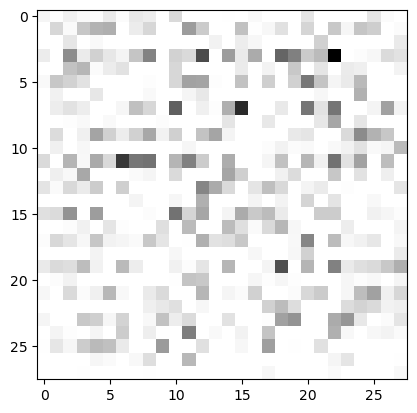

[1/3][0/60000]	Loss_D: -0.0005	Loss_G: 3.1799
[1/3][800/60000]	Loss_D: 0.3231	Loss_G: -3.7717
[1/3][1600/60000]	Loss_D: -0.2139	Loss_G: -2.7489
[1/3][2400/60000]	Loss_D: -1.5634	Loss_G: -1.6980
[1/3][3200/60000]	Loss_D: -0.4669	Loss_G: -4.0023
Loss G: tensor(-4.2678, grad_fn=<NegBackward0>) Loss D: tensor(-0.6681, grad_fn=<AddBackward0>)


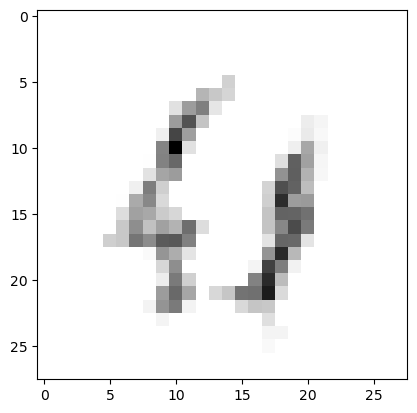

[1/3][4000/60000]	Loss_D: -0.6681	Loss_G: -4.2678
[1/3][4800/60000]	Loss_D: 0.8601	Loss_G: -5.0244
[1/3][5600/60000]	Loss_D: -1.3939	Loss_G: -3.6356
[1/3][6400/60000]	Loss_D: -1.6297	Loss_G: -5.0260
[1/3][7200/60000]	Loss_D: -0.5612	Loss_G: -5.6721
Loss G: tensor(-2.8824, grad_fn=<NegBackward0>) Loss D: tensor(-4.3577, grad_fn=<AddBackward0>)


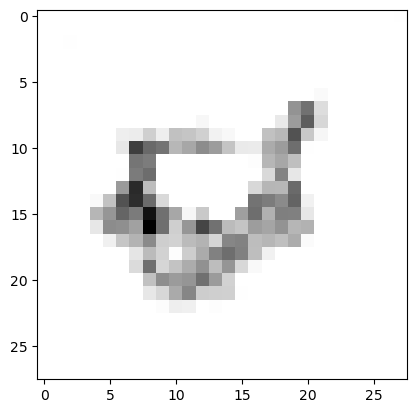

[1/3][8000/60000]	Loss_D: -4.3577	Loss_G: -2.8824
[1/3][8800/60000]	Loss_D: 0.1233	Loss_G: -5.9326
[1/3][9600/60000]	Loss_D: -1.0439	Loss_G: -4.8197
[1/3][10400/60000]	Loss_D: 0.9719	Loss_G: -2.5973
[1/3][11200/60000]	Loss_D: -1.2678	Loss_G: -8.0069
Loss G: tensor(-8.2188, grad_fn=<NegBackward0>) Loss D: tensor(-2.4893, grad_fn=<AddBackward0>)


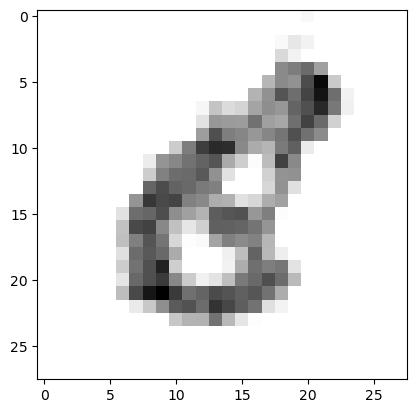

[1/3][12000/60000]	Loss_D: -2.4893	Loss_G: -8.2188
[1/3][12800/60000]	Loss_D: -5.5625	Loss_G: -3.6380
[1/3][13600/60000]	Loss_D: -2.6540	Loss_G: -5.6665
[1/3][14400/60000]	Loss_D: -2.4171	Loss_G: -12.0403
[1/3][15200/60000]	Loss_D: 2.9352	Loss_G: -8.3380
Loss G: tensor(-26.4804, grad_fn=<NegBackward0>) Loss D: tensor(-2.8190, grad_fn=<AddBackward0>)


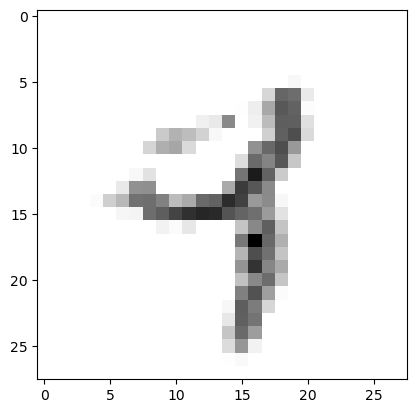

[1/3][16000/60000]	Loss_D: -2.8190	Loss_G: -26.4804
[1/3][16800/60000]	Loss_D: -0.9501	Loss_G: -9.9654
[1/3][17600/60000]	Loss_D: -3.2271	Loss_G: -11.9456
[1/3][18400/60000]	Loss_D: -4.6023	Loss_G: -13.2020
[1/3][19200/60000]	Loss_D: -2.0550	Loss_G: -13.8389
Loss G: tensor(-16.4512, grad_fn=<NegBackward0>) Loss D: tensor(4.5608, grad_fn=<AddBackward0>)


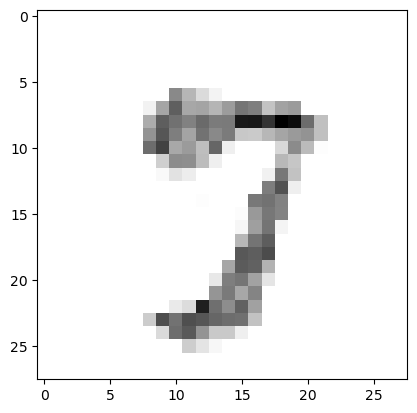

[1/3][20000/60000]	Loss_D: 4.5608	Loss_G: -16.4512
[1/3][20800/60000]	Loss_D: -11.6598	Loss_G: -18.4335
[1/3][21600/60000]	Loss_D: -8.5024	Loss_G: -7.1051
[1/3][22400/60000]	Loss_D: -7.4175	Loss_G: -27.5116
[1/3][23200/60000]	Loss_D: -5.0443	Loss_G: -15.5188
Loss G: tensor(-32.4122, grad_fn=<NegBackward0>) Loss D: tensor(3.3706, grad_fn=<AddBackward0>)


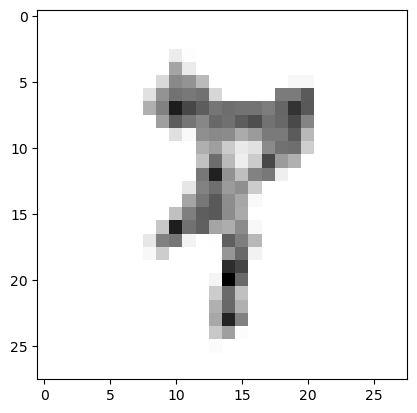

[1/3][24000/60000]	Loss_D: 3.3706	Loss_G: -32.4122
[1/3][24800/60000]	Loss_D: -7.8359	Loss_G: -44.1927
[1/3][25600/60000]	Loss_D: -9.9453	Loss_G: -4.8826
[1/3][26400/60000]	Loss_D: -6.9822	Loss_G: -23.9093
[1/3][27200/60000]	Loss_D: -3.1696	Loss_G: -18.9881
Loss G: tensor(-30.5600, grad_fn=<NegBackward0>) Loss D: tensor(-3.8647, grad_fn=<AddBackward0>)


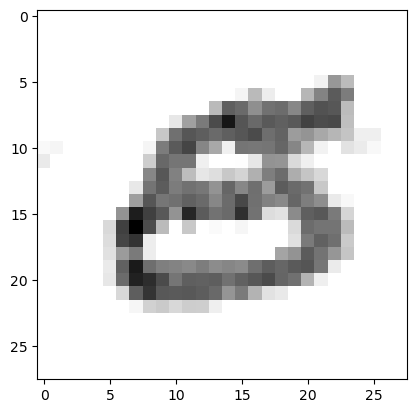

[1/3][28000/60000]	Loss_D: -3.8647	Loss_G: -30.5600
[1/3][28800/60000]	Loss_D: -6.8188	Loss_G: -25.2149
[1/3][29600/60000]	Loss_D: -11.9798	Loss_G: -12.6210
[1/3][30400/60000]	Loss_D: -38.1481	Loss_G: -19.3526
[1/3][31200/60000]	Loss_D: -21.0616	Loss_G: 6.5754
Loss G: tensor(-30.1331, grad_fn=<NegBackward0>) Loss D: tensor(-4.0490, grad_fn=<AddBackward0>)


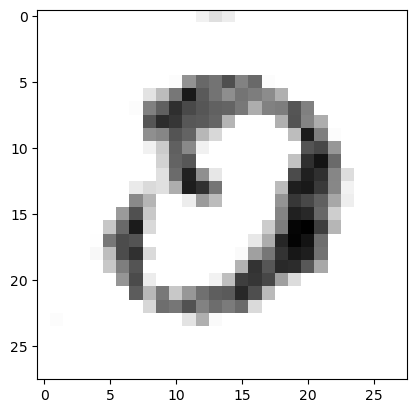

[1/3][32000/60000]	Loss_D: -4.0490	Loss_G: -30.1331
[1/3][32800/60000]	Loss_D: -28.4493	Loss_G: -15.5859
[1/3][33600/60000]	Loss_D: -15.4004	Loss_G: -14.7386
[1/3][34400/60000]	Loss_D: -0.8051	Loss_G: -25.3740
[1/3][35200/60000]	Loss_D: 6.5448	Loss_G: -26.6354
Loss G: tensor(-21.7090, grad_fn=<NegBackward0>) Loss D: tensor(2.7994, grad_fn=<AddBackward0>)


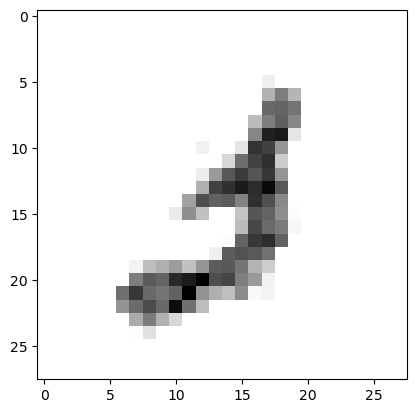

[1/3][36000/60000]	Loss_D: 2.7994	Loss_G: -21.7090
[1/3][36800/60000]	Loss_D: 16.2747	Loss_G: -46.8728
[1/3][37600/60000]	Loss_D: -46.2895	Loss_G: 28.1280
[1/3][38400/60000]	Loss_D: -15.0674	Loss_G: -42.5003
[1/3][39200/60000]	Loss_D: -0.6440	Loss_G: -73.6705
Loss G: tensor(-61.1135, grad_fn=<NegBackward0>) Loss D: tensor(-7.1658, grad_fn=<AddBackward0>)


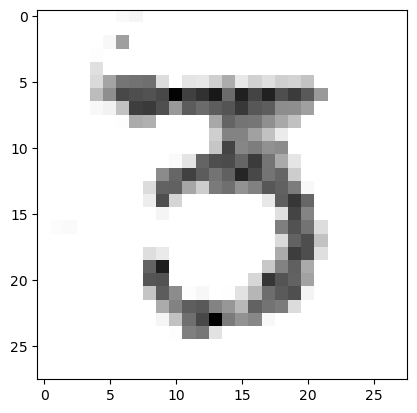

[1/3][40000/60000]	Loss_D: -7.1658	Loss_G: -61.1135
[1/3][40800/60000]	Loss_D: -6.1415	Loss_G: -14.2287
[1/3][41600/60000]	Loss_D: 4.5031	Loss_G: -77.2451
[1/3][42400/60000]	Loss_D: -23.7821	Loss_G: 8.9566
[1/3][43200/60000]	Loss_D: -25.4613	Loss_G: -84.2724
Loss G: tensor(-40.3294, grad_fn=<NegBackward0>) Loss D: tensor(-15.5717, grad_fn=<AddBackward0>)


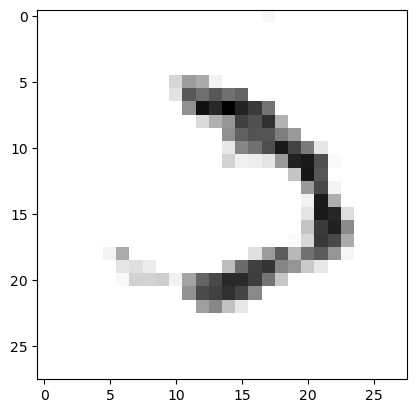

[1/3][44000/60000]	Loss_D: -15.5717	Loss_G: -40.3294
[1/3][44800/60000]	Loss_D: -15.8607	Loss_G: -36.6579
[1/3][45600/60000]	Loss_D: 5.9416	Loss_G: -65.4148
[1/3][46400/60000]	Loss_D: 2.0733	Loss_G: -52.3468
[1/3][47200/60000]	Loss_D: -10.4453	Loss_G: -51.5004
Loss G: tensor(-32.5367, grad_fn=<NegBackward0>) Loss D: tensor(-19.8919, grad_fn=<AddBackward0>)


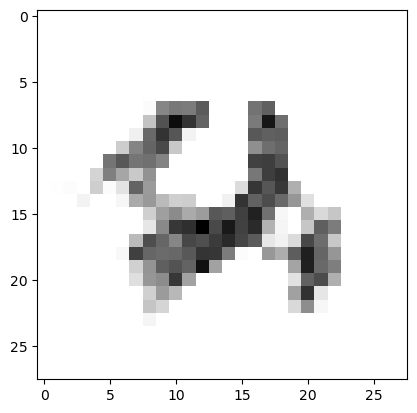

[1/3][48000/60000]	Loss_D: -19.8919	Loss_G: -32.5367
[1/3][48800/60000]	Loss_D: -2.2895	Loss_G: -66.3648
[1/3][49600/60000]	Loss_D: 6.2043	Loss_G: -61.8089
[1/3][50400/60000]	Loss_D: -22.5514	Loss_G: -25.0049
[1/3][51200/60000]	Loss_D: -29.1295	Loss_G: -103.9399
Loss G: tensor(-66.8324, grad_fn=<NegBackward0>) Loss D: tensor(2.8847, grad_fn=<AddBackward0>)


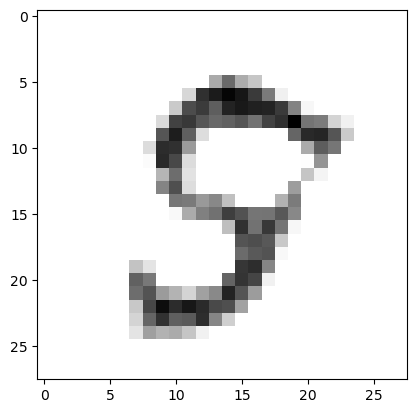

[1/3][52000/60000]	Loss_D: 2.8847	Loss_G: -66.8324
[1/3][52800/60000]	Loss_D: -0.3829	Loss_G: -80.0415
[1/3][53600/60000]	Loss_D: -3.3251	Loss_G: -43.6130
[1/3][54400/60000]	Loss_D: -26.1854	Loss_G: -53.9934
[1/3][55200/60000]	Loss_D: -12.8804	Loss_G: -82.2463
Loss G: tensor(-71.8070, grad_fn=<NegBackward0>) Loss D: tensor(2.9850, grad_fn=<AddBackward0>)


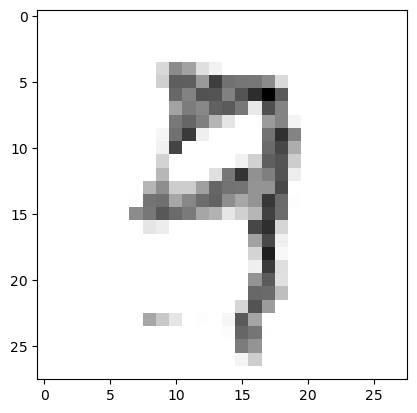

[1/3][56000/60000]	Loss_D: 2.9850	Loss_G: -71.8070
[1/3][56800/60000]	Loss_D: -19.4981	Loss_G: -46.0127
[1/3][57600/60000]	Loss_D: -37.4155	Loss_G: -75.5998
[1/3][58400/60000]	Loss_D: 26.7072	Loss_G: -131.3821
[1/3][59200/60000]	Loss_D: -17.5604	Loss_G: -60.7231
Loss G: tensor(-49.3962, grad_fn=<NegBackward0>) Loss D: tensor(24.7264, grad_fn=<AddBackward0>)


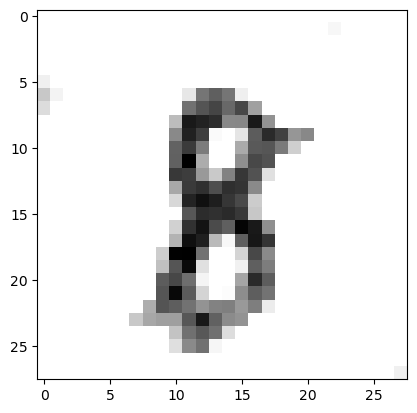

[2/3][0/60000]	Loss_D: 24.7264	Loss_G: -49.3962
[2/3][800/60000]	Loss_D: -10.3591	Loss_G: -47.3613
[2/3][1600/60000]	Loss_D: -1.8213	Loss_G: -21.0402
[2/3][2400/60000]	Loss_D: -2.1294	Loss_G: -52.1462
[2/3][3200/60000]	Loss_D: -15.3897	Loss_G: -63.2394
Loss G: tensor(-54.0092, grad_fn=<NegBackward0>) Loss D: tensor(-37.7915, grad_fn=<AddBackward0>)


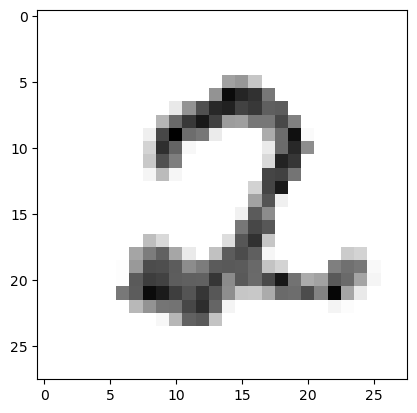

[2/3][4000/60000]	Loss_D: -37.7915	Loss_G: -54.0092
[2/3][4800/60000]	Loss_D: -30.0880	Loss_G: 50.0642
[2/3][5600/60000]	Loss_D: 15.2421	Loss_G: -133.5774
[2/3][6400/60000]	Loss_D: 2.6922	Loss_G: -28.3733
[2/3][7200/60000]	Loss_D: -6.3228	Loss_G: -112.6945
Loss G: tensor(-37.3450, grad_fn=<NegBackward0>) Loss D: tensor(-27.3764, grad_fn=<AddBackward0>)


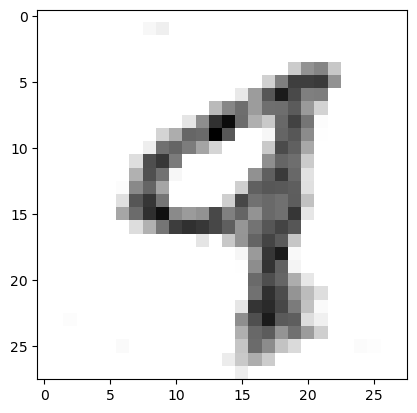

[2/3][8000/60000]	Loss_D: -27.3764	Loss_G: -37.3450
[2/3][8800/60000]	Loss_D: -32.4833	Loss_G: -24.8368
[2/3][9600/60000]	Loss_D: 6.0647	Loss_G: -74.8329
[2/3][10400/60000]	Loss_D: -2.2806	Loss_G: -59.4931
[2/3][11200/60000]	Loss_D: -4.3808	Loss_G: -77.8575
Loss G: tensor(-136.2178, grad_fn=<NegBackward0>) Loss D: tensor(6.8723, grad_fn=<AddBackward0>)


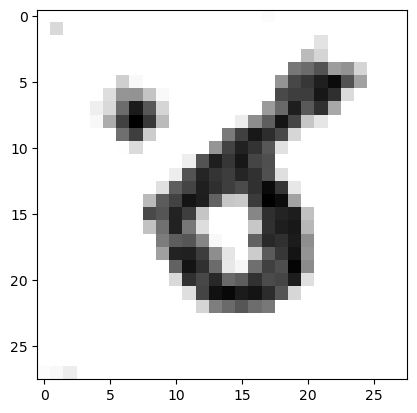

[2/3][12000/60000]	Loss_D: 6.8723	Loss_G: -136.2178
[2/3][12800/60000]	Loss_D: -44.2887	Loss_G: -46.0020
[2/3][13600/60000]	Loss_D: -15.4906	Loss_G: -75.5825
[2/3][14400/60000]	Loss_D: 33.1835	Loss_G: -140.9857
[2/3][15200/60000]	Loss_D: 19.6643	Loss_G: -75.8158
Loss G: tensor(-77.4466, grad_fn=<NegBackward0>) Loss D: tensor(-30.0161, grad_fn=<AddBackward0>)


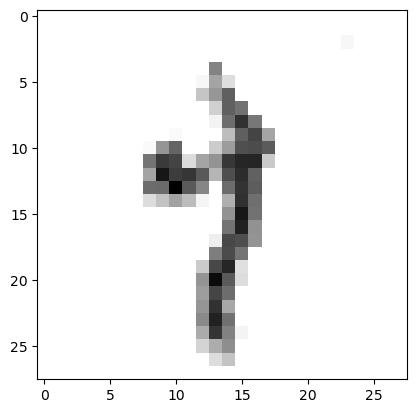

[2/3][16000/60000]	Loss_D: -30.0161	Loss_G: -77.4466
[2/3][16800/60000]	Loss_D: 6.6826	Loss_G: -65.0777
[2/3][17600/60000]	Loss_D: 3.6148	Loss_G: -76.2564
[2/3][18400/60000]	Loss_D: -49.5466	Loss_G: -67.9188
[2/3][19200/60000]	Loss_D: -50.8588	Loss_G: -104.1853
Loss G: tensor(5.0574, grad_fn=<NegBackward0>) Loss D: tensor(-41.6971, grad_fn=<AddBackward0>)


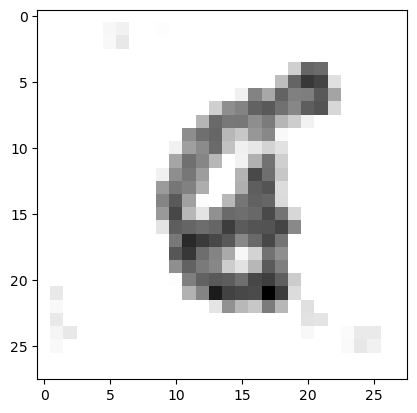

[2/3][20000/60000]	Loss_D: -41.6971	Loss_G: 5.0574
[2/3][20800/60000]	Loss_D: -49.4200	Loss_G: -188.7692
[2/3][21600/60000]	Loss_D: -31.7881	Loss_G: -54.1677
[2/3][22400/60000]	Loss_D: -42.2407	Loss_G: -176.7898
[2/3][23200/60000]	Loss_D: 44.1336	Loss_G: -22.0886
Loss G: tensor(-201.5608, grad_fn=<NegBackward0>) Loss D: tensor(-19.3560, grad_fn=<AddBackward0>)


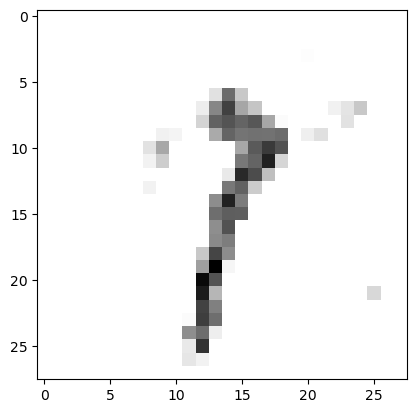

[2/3][24000/60000]	Loss_D: -19.3560	Loss_G: -201.5608
[2/3][24800/60000]	Loss_D: -47.7519	Loss_G: -68.8518
[2/3][25600/60000]	Loss_D: -51.7515	Loss_G: -124.2558
[2/3][26400/60000]	Loss_D: -9.9919	Loss_G: -174.4688
[2/3][27200/60000]	Loss_D: 0.5183	Loss_G: -159.8940
Loss G: tensor(-181.7555, grad_fn=<NegBackward0>) Loss D: tensor(-23.3920, grad_fn=<AddBackward0>)


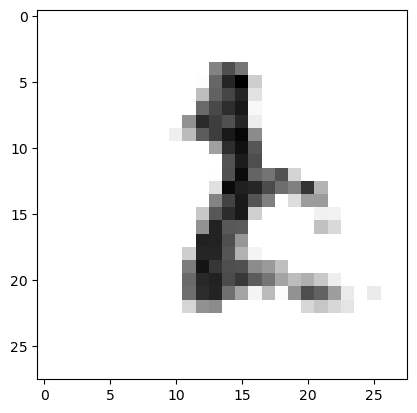

[2/3][28000/60000]	Loss_D: -23.3920	Loss_G: -181.7555
[2/3][28800/60000]	Loss_D: -31.0533	Loss_G: -155.1565
[2/3][29600/60000]	Loss_D: -99.7172	Loss_G: 37.1338
[2/3][30400/60000]	Loss_D: -192.6999	Loss_G: 16.7399
[2/3][31200/60000]	Loss_D: -39.7247	Loss_G: 14.9381
Loss G: tensor(-122.5049, grad_fn=<NegBackward0>) Loss D: tensor(-15.9677, grad_fn=<AddBackward0>)


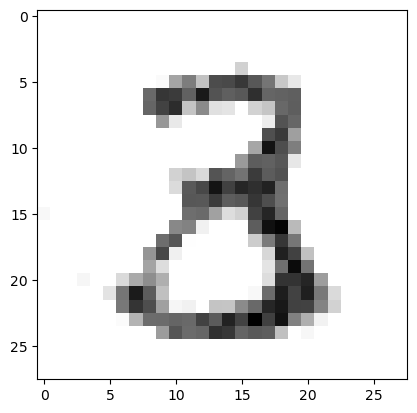

[2/3][32000/60000]	Loss_D: -15.9677	Loss_G: -122.5049
[2/3][32800/60000]	Loss_D: -70.1336	Loss_G: 35.1284
[2/3][33600/60000]	Loss_D: -3.6789	Loss_G: -49.7881
[2/3][34400/60000]	Loss_D: 37.0231	Loss_G: -201.8202
[2/3][35200/60000]	Loss_D: -17.5676	Loss_G: -188.7188
Loss G: tensor(-61.1460, grad_fn=<NegBackward0>) Loss D: tensor(38.7252, grad_fn=<AddBackward0>)


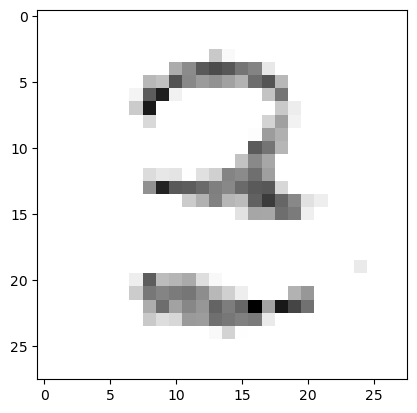

[2/3][36000/60000]	Loss_D: 38.7252	Loss_G: -61.1460
[2/3][36800/60000]	Loss_D: 0.5324	Loss_G: -237.2579
[2/3][37600/60000]	Loss_D: -140.4007	Loss_G: 100.6656
[2/3][38400/60000]	Loss_D: -29.0456	Loss_G: -145.2023
[2/3][39200/60000]	Loss_D: -48.1934	Loss_G: -150.2617
Loss G: tensor(-163.5714, grad_fn=<NegBackward0>) Loss D: tensor(-15.1940, grad_fn=<AddBackward0>)


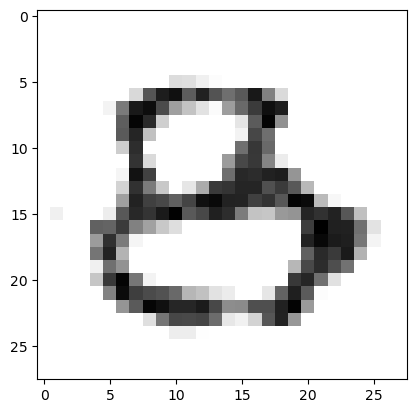

[2/3][40000/60000]	Loss_D: -15.1940	Loss_G: -163.5714
[2/3][40800/60000]	Loss_D: -88.5495	Loss_G: 112.4502
[2/3][41600/60000]	Loss_D: -74.5818	Loss_G: -210.1378
[2/3][42400/60000]	Loss_D: 18.1005	Loss_G: -19.8459
[2/3][43200/60000]	Loss_D: -125.3539	Loss_G: -199.8866
Loss G: tensor(-152.1882, grad_fn=<NegBackward0>) Loss D: tensor(-8.7043, grad_fn=<AddBackward0>)


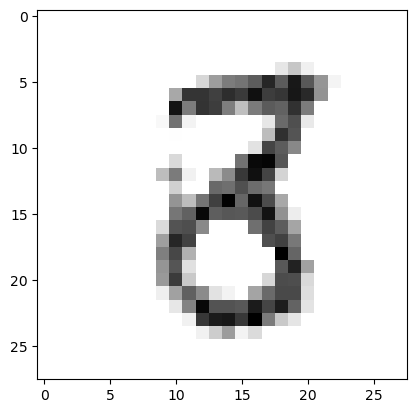

[2/3][44000/60000]	Loss_D: -8.7043	Loss_G: -152.1882
[2/3][44800/60000]	Loss_D: -84.3074	Loss_G: -59.5981
[2/3][45600/60000]	Loss_D: -90.4099	Loss_G: -97.9837
[2/3][46400/60000]	Loss_D: -36.1857	Loss_G: -199.5346
[2/3][47200/60000]	Loss_D: -55.7560	Loss_G: -103.0613
Loss G: tensor(-44.0924, grad_fn=<NegBackward0>) Loss D: tensor(-76.4051, grad_fn=<AddBackward0>)


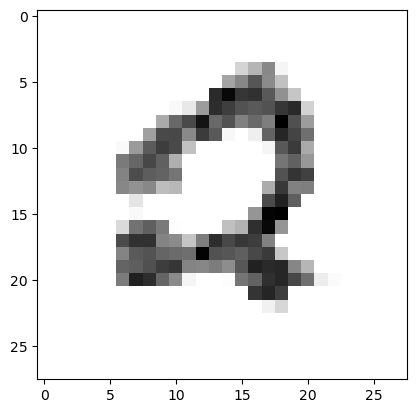

[2/3][48000/60000]	Loss_D: -76.4051	Loss_G: -44.0924
[2/3][48800/60000]	Loss_D: -7.6635	Loss_G: -96.6055
[2/3][49600/60000]	Loss_D: 53.0785	Loss_G: -276.0579
[2/3][50400/60000]	Loss_D: -2.3925	Loss_G: -180.1006
[2/3][51200/60000]	Loss_D: -63.9008	Loss_G: -381.5320
Loss G: tensor(-330.8533, grad_fn=<NegBackward0>) Loss D: tensor(-25.7129, grad_fn=<AddBackward0>)


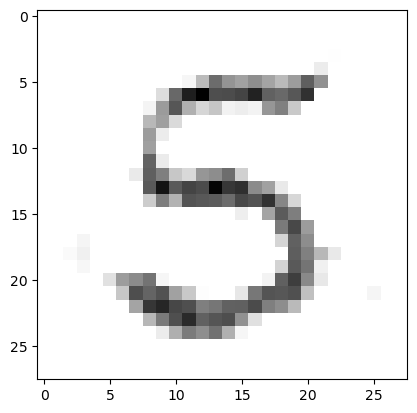

[2/3][52000/60000]	Loss_D: -25.7129	Loss_G: -330.8533
[2/3][52800/60000]	Loss_D: -41.2241	Loss_G: -187.7606
[2/3][53600/60000]	Loss_D: -87.7692	Loss_G: 111.6049
[2/3][54400/60000]	Loss_D: -102.0110	Loss_G: -141.7509
[2/3][55200/60000]	Loss_D: 41.2934	Loss_G: -232.8501
Loss G: tensor(-86.0836, grad_fn=<NegBackward0>) Loss D: tensor(-52.3898, grad_fn=<AddBackward0>)


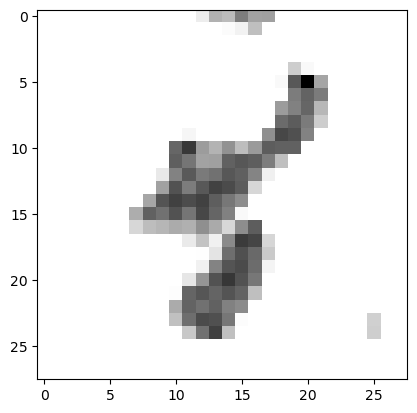

[2/3][56000/60000]	Loss_D: -52.3898	Loss_G: -86.0836
[2/3][56800/60000]	Loss_D: -146.2012	Loss_G: -37.6647
[2/3][57600/60000]	Loss_D: -234.1959	Loss_G: -268.6090
[2/3][58400/60000]	Loss_D: 154.8345	Loss_G: -485.2061
[2/3][59200/60000]	Loss_D: -84.3451	Loss_G: -145.7803
Loss G: tensor(-133.5191, grad_fn=<NegBackward0>) Loss D: tensor(-24.5333, grad_fn=<AddBackward0>)


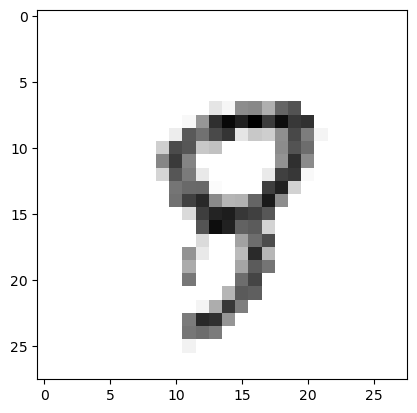

[3/3][0/60000]	Loss_D: -24.5333	Loss_G: -133.5191
[3/3][800/60000]	Loss_D: -89.9583	Loss_G: -73.4380
[3/3][1600/60000]	Loss_D: 10.4285	Loss_G: -87.0550
[3/3][2400/60000]	Loss_D: -54.1061	Loss_G: -55.6094
[3/3][3200/60000]	Loss_D: -5.9982	Loss_G: -288.3282
Loss G: tensor(-88.4413, grad_fn=<NegBackward0>) Loss D: tensor(-96.3562, grad_fn=<AddBackward0>)


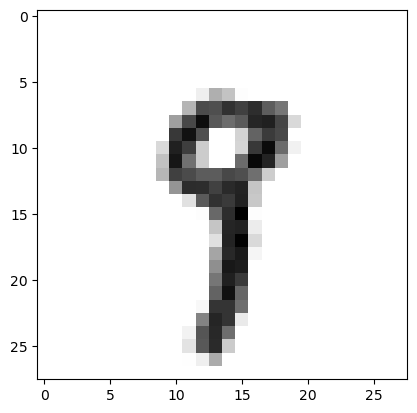

[3/3][4000/60000]	Loss_D: -96.3562	Loss_G: -88.4413
[3/3][4800/60000]	Loss_D: -170.2553	Loss_G: 198.9471
[3/3][5600/60000]	Loss_D: 71.6178	Loss_G: -358.5098
[3/3][6400/60000]	Loss_D: 3.4205	Loss_G: -28.6646
[3/3][7200/60000]	Loss_D: -63.6736	Loss_G: -211.5181
Loss G: tensor(-229.5720, grad_fn=<NegBackward0>) Loss D: tensor(-42.3183, grad_fn=<AddBackward0>)


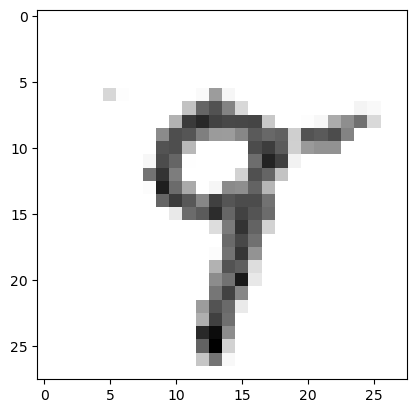

[3/3][8000/60000]	Loss_D: -42.3183	Loss_G: -229.5720
[3/3][8800/60000]	Loss_D: -86.1411	Loss_G: 180.5512
[3/3][9600/60000]	Loss_D: -71.3550	Loss_G: -198.7755
[3/3][10400/60000]	Loss_D: -150.2492	Loss_G: -34.7807
[3/3][11200/60000]	Loss_D: -58.1115	Loss_G: -174.4666
Loss G: tensor(-335.3628, grad_fn=<NegBackward0>) Loss D: tensor(-7.0953, grad_fn=<AddBackward0>)


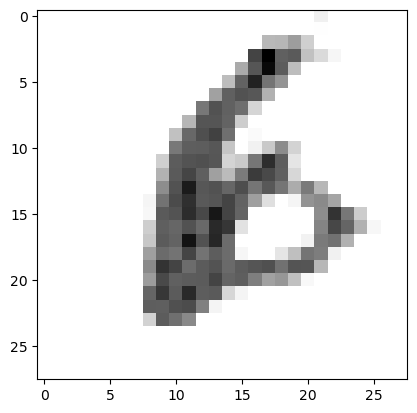

[3/3][12000/60000]	Loss_D: -7.0953	Loss_G: -335.3628
[3/3][12800/60000]	Loss_D: -113.4197	Loss_G: -19.4558
[3/3][13600/60000]	Loss_D: -65.5776	Loss_G: -230.9717
[3/3][14400/60000]	Loss_D: -91.9283	Loss_G: -131.9366
[3/3][15200/60000]	Loss_D: 18.6053	Loss_G: -115.0353
Loss G: tensor(-180.8897, grad_fn=<NegBackward0>) Loss D: tensor(-34.2240, grad_fn=<AddBackward0>)


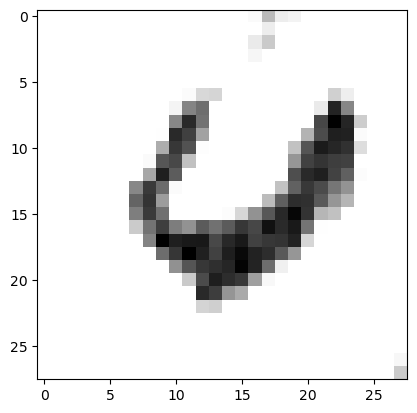

[3/3][16000/60000]	Loss_D: -34.2240	Loss_G: -180.8897
[3/3][16800/60000]	Loss_D: -23.5720	Loss_G: -119.8901
[3/3][17600/60000]	Loss_D: -4.7625	Loss_G: -269.5445
[3/3][18400/60000]	Loss_D: -65.3343	Loss_G: -320.7167
[3/3][19200/60000]	Loss_D: -181.2400	Loss_G: -344.7858
Loss G: tensor(189.6159, grad_fn=<NegBackward0>) Loss D: tensor(-75.9619, grad_fn=<AddBackward0>)


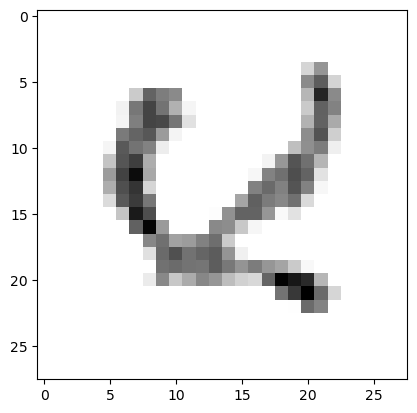

[3/3][20000/60000]	Loss_D: -75.9619	Loss_G: 189.6159
[3/3][20800/60000]	Loss_D: -231.3685	Loss_G: -414.4645
[3/3][21600/60000]	Loss_D: -131.7000	Loss_G: -66.7953
[3/3][22400/60000]	Loss_D: -110.1850	Loss_G: -479.0243
[3/3][23200/60000]	Loss_D: -198.6052	Loss_G: 173.2788
Loss G: tensor(-431.8516, grad_fn=<NegBackward0>) Loss D: tensor(-150.3735, grad_fn=<AddBackward0>)


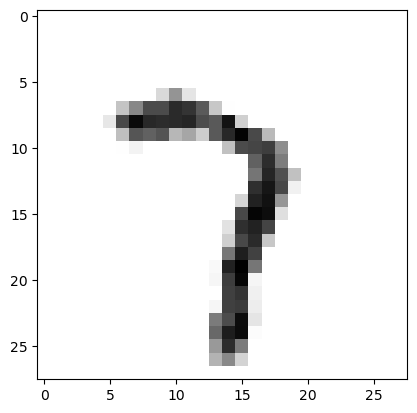

[3/3][24000/60000]	Loss_D: -150.3735	Loss_G: -431.8516
[3/3][24800/60000]	Loss_D: -164.1605	Loss_G: -209.0804
[3/3][25600/60000]	Loss_D: -54.2033	Loss_G: -192.8090
[3/3][26400/60000]	Loss_D: -113.4922	Loss_G: -360.7932
[3/3][27200/60000]	Loss_D: -17.4625	Loss_G: -369.5363
Loss G: tensor(-495.7682, grad_fn=<NegBackward0>) Loss D: tensor(-101.2855, grad_fn=<AddBackward0>)


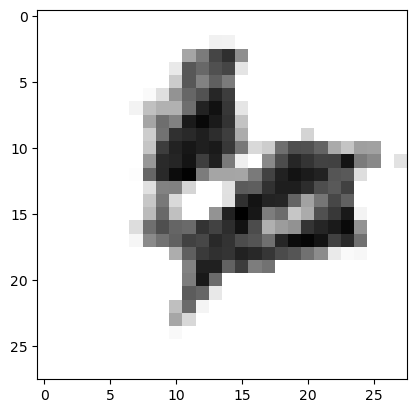

[3/3][28000/60000]	Loss_D: -101.2855	Loss_G: -495.7682
[3/3][28800/60000]	Loss_D: -131.9443	Loss_G: -132.0375
[3/3][29600/60000]	Loss_D: -84.5329	Loss_G: 21.0941
[3/3][30400/60000]	Loss_D: -360.1386	Loss_G: 362.7881
[3/3][31200/60000]	Loss_D: -146.2180	Loss_G: 151.6915
Loss G: tensor(-207.3826, grad_fn=<NegBackward0>) Loss D: tensor(-29.6222, grad_fn=<AddBackward0>)


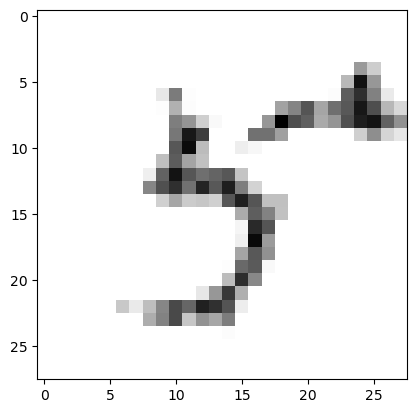

[3/3][32000/60000]	Loss_D: -29.6222	Loss_G: -207.3826
[3/3][32800/60000]	Loss_D: -315.5579	Loss_G: 234.8111
[3/3][33600/60000]	Loss_D: -32.8894	Loss_G: -173.2048
[3/3][34400/60000]	Loss_D: -24.5699	Loss_G: -274.3908
[3/3][35200/60000]	Loss_D: -32.4199	Loss_G: -350.6765
Loss G: tensor(326.0452, grad_fn=<NegBackward0>) Loss D: tensor(35.5951, grad_fn=<AddBackward0>)


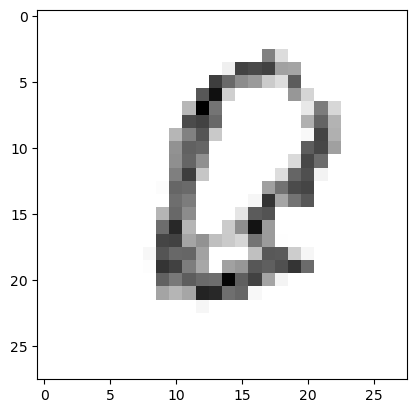

[3/3][36000/60000]	Loss_D: 35.5951	Loss_G: 326.0452
[3/3][36800/60000]	Loss_D: -140.3248	Loss_G: -314.5927
[3/3][37600/60000]	Loss_D: -303.9176	Loss_G: 305.7548
[3/3][38400/60000]	Loss_D: -54.5878	Loss_G: -466.3194
[3/3][39200/60000]	Loss_D: 30.7883	Loss_G: -384.8350
Loss G: tensor(-374.3705, grad_fn=<NegBackward0>) Loss D: tensor(-186.4211, grad_fn=<AddBackward0>)


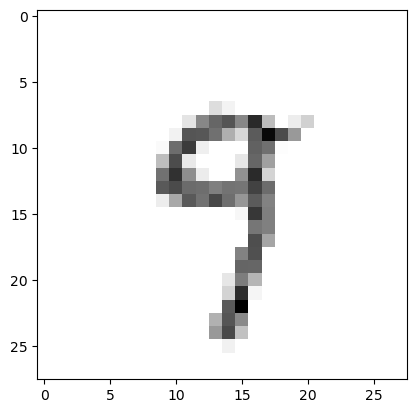

[3/3][40000/60000]	Loss_D: -186.4211	Loss_G: -374.3705
[3/3][40800/60000]	Loss_D: -115.5979	Loss_G: -127.8492
[3/3][41600/60000]	Loss_D: -38.4542	Loss_G: -511.1674
[3/3][42400/60000]	Loss_D: -206.8895	Loss_G: 342.7848
[3/3][43200/60000]	Loss_D: -188.1570	Loss_G: -703.3694
Loss G: tensor(-33.2631, grad_fn=<NegBackward0>) Loss D: tensor(-99.6407, grad_fn=<AddBackward0>)


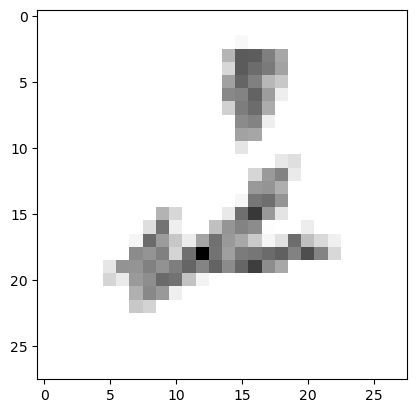

[3/3][44000/60000]	Loss_D: -99.6407	Loss_G: -33.2631
[3/3][44800/60000]	Loss_D: -359.7013	Loss_G: 241.9196
[3/3][45600/60000]	Loss_D: 10.0090	Loss_G: -330.1271
[3/3][46400/60000]	Loss_D: -87.1583	Loss_G: -424.9070
[3/3][47200/60000]	Loss_D: -38.8013	Loss_G: -209.0169
Loss G: tensor(-623.7899, grad_fn=<NegBackward0>) Loss D: tensor(171.2845, grad_fn=<AddBackward0>)


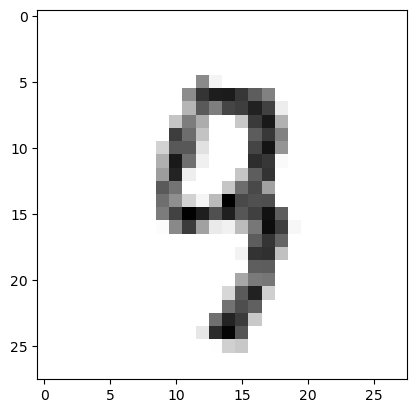

[3/3][48000/60000]	Loss_D: 171.2845	Loss_G: -623.7899
[3/3][48800/60000]	Loss_D: 25.2855	Loss_G: -186.7991
[3/3][49600/60000]	Loss_D: 109.4361	Loss_G: -373.2971
[3/3][50400/60000]	Loss_D: -39.8234	Loss_G: -449.7493
[3/3][51200/60000]	Loss_D: -142.6291	Loss_G: -725.6316
Loss G: tensor(-402.3795, grad_fn=<NegBackward0>) Loss D: tensor(-42.2236, grad_fn=<AddBackward0>)


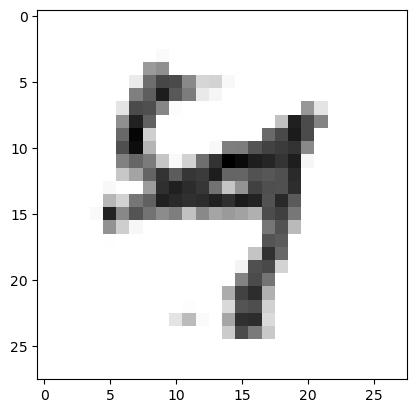

[3/3][52000/60000]	Loss_D: -42.2236	Loss_G: -402.3795
[3/3][52800/60000]	Loss_D: -17.8033	Loss_G: -419.3469
[3/3][53600/60000]	Loss_D: -46.1234	Loss_G: 81.6319
[3/3][54400/60000]	Loss_D: -179.3250	Loss_G: -337.1379
[3/3][55200/60000]	Loss_D: -49.8769	Loss_G: -420.7402
Loss G: tensor(-290.6107, grad_fn=<NegBackward0>) Loss D: tensor(63.8248, grad_fn=<AddBackward0>)


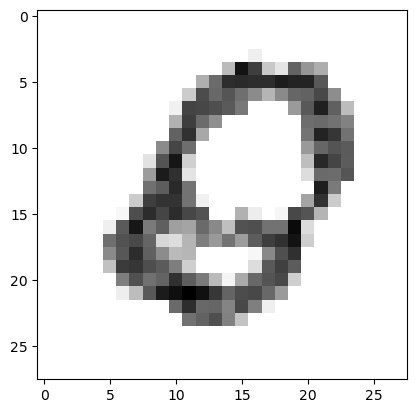

[3/3][56000/60000]	Loss_D: 63.8248	Loss_G: -290.6107
[3/3][56800/60000]	Loss_D: -340.3895	Loss_G: -24.4228
[3/3][57600/60000]	Loss_D: -403.6335	Loss_G: -675.8682
[3/3][58400/60000]	Loss_D: 127.4734	Loss_G: -638.6351
[3/3][59200/60000]	Loss_D: -266.4451	Loss_G: -447.4662


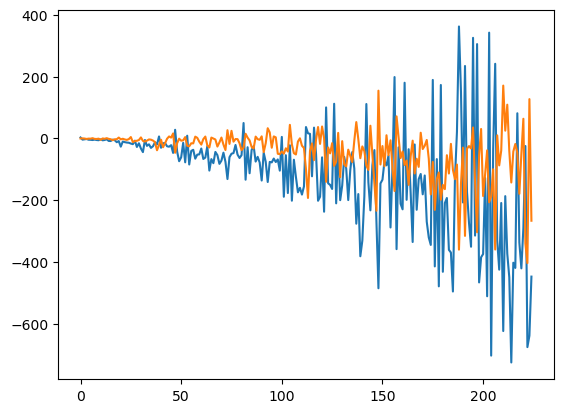

In [27]:
num_epochs = 3
real_label = 1
fake_label = 0

cum_data = {'d_loss': [], 'g_loss': [], 'fid_scores': [], 'generated_image': [], 'real_image': []}
for e in range(num_epochs):
    done = True

    for n, (real_samples, _) in enumerate(data_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn(batch_size, 20, 1, 1)

        # Zero gradients
        model_D.zero_grad()

        # Generate fake samples
        generated_samples = model_G(latent_space_samples)

        # TRAIN ON REAL SAMPLES
        # Real samples through Discriminator
        D_scores_on_real = model_D(real_samples).view(-1)

        # TRAIN ON FAKE SAMPLES
        D_scores_on_fake = model_D(generated_samples).view(-1)
        '''loss_d1 = criterion(D_scores_on_real, torch.ones(8))
        loss_d2 = criterion(D_scores_on_fake, torch.zeros(8))

        loss_d = loss_d1 + '''
        loss_d = - D_scores_on_real.mean() + D_scores_on_fake.mean()
        loss_d.backward(retain_graph=True)
        optimizer_D.step()

        # Update G network
        model_G.zero_grad()
        D_scores_on_fake2 = model_D(generated_samples).view(-1)
        loss_g = -D_scores_on_fake2.mean()
        loss_g.backward(retain_graph=True)
        optimizer_G.step()


        if n % 500 == 0:
            # Bookkeeping
            done = False
            '''loss_g = - D_scores_on_fake.mean()
            loss_d = D_scores_on_real.mean() - D_scores_on_fake.mean()'''
            print("Loss G:", loss_g, "Loss D:", loss_d)

            plt.imshow(generated_samples[0][0].detach(), cmap='Greys')
            plt.show()
        if n % 100 == 0:
            '''loss_g = - D_scores_on_fake.mean()
            loss_d = D_scores_on_real.mean() - D_scores_on_fake.mean()'''

            cum_data['g_loss'].append(loss_g.detach())
            cum_data['d_loss'].append(loss_d.detach())
            cum_data['generated_image'].append(generated_samples)
            cum_data['real_image'].append(real_samples)
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (e+1, num_epochs, n*batch_size, len(training_data),
                     loss_d, loss_g))


plt.plot(cum_data['g_loss'])
plt.plot(cum_data['d_loss'])
plt.show()

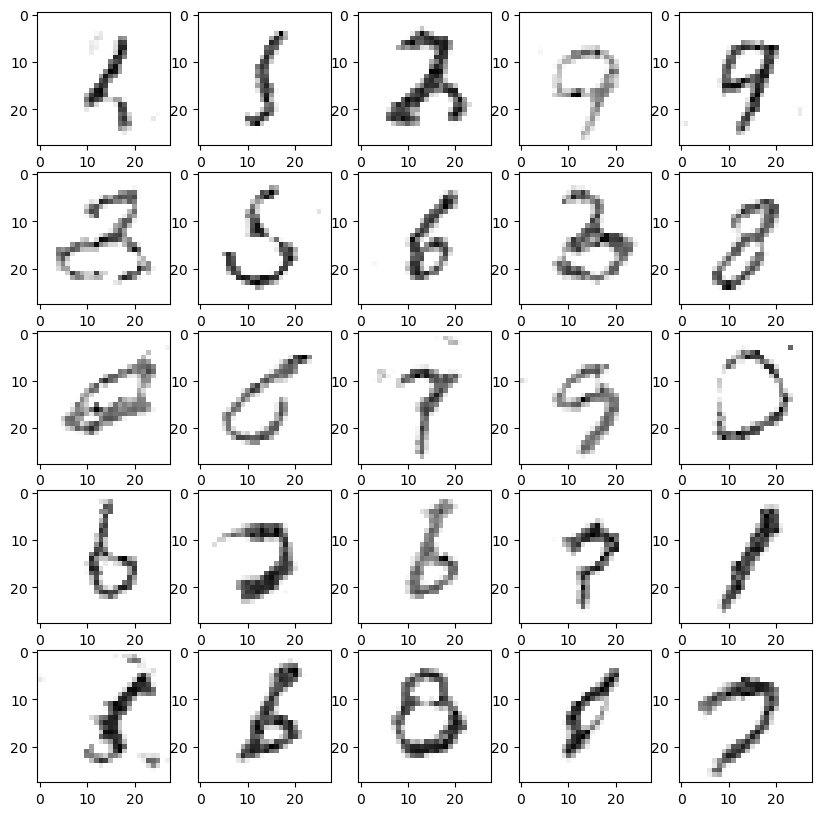

In [28]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        noise = torch.randn((batch_size, 20, 1, 1))
        im = model_G(noise)
        im = im.detach()


        axs[i][j].imshow(im[0][0], cmap='Greys')



In [29]:
print(cum_data['generated_image'][1].shape)
print(cum_data['real_image'][0].shape)
z2 = torch.zeros((batch_size, 1, 28, 28))
for i in range(len(cum_data['generated_image'])):
    cum_data['generated_image'][i] = torch.cat((cum_data['generated_image'][i], z2, z2), dim=1)

torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])


In [30]:
for i in range(len(cum_data['real_image'])):
    cum_data['real_image'][i] = torch.cat((cum_data['real_image'][i], z2, z2), dim=1)

In [31]:
'''for i in range(len(cum_data['generated_image'])):
    mu1, sig1 = statistics(cum_data['real_image'][i], inception)
    mu2, sig2 = statistics(cum_data['generated_image'][i], inception)
    fid_score = calculate_frechet_distance(mu1, sig1, mu2, sig2)
    cum_data['fid_scores'].append(fid_score)'''

"for i in range(len(cum_data['generated_image'])):\n    mu1, sig1 = statistics(cum_data['real_image'][i], inception)\n    mu2, sig2 = statistics(cum_data['generated_image'][i], inception)\n    fid_score = calculate_frechet_distance(mu1, sig1, mu2, sig2)\n    cum_data['fid_scores'].append(fid_score)"

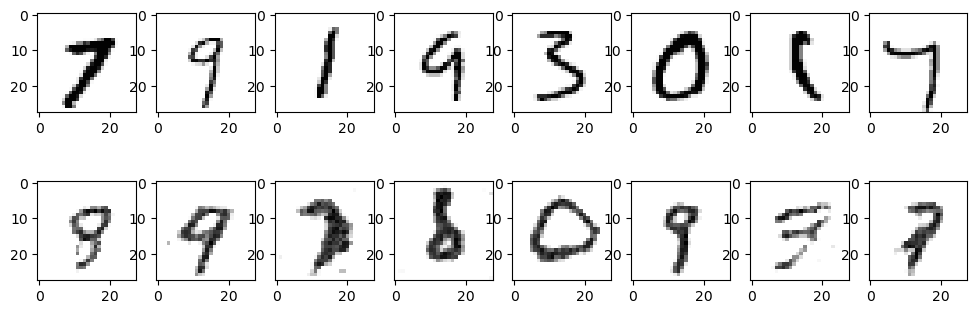

In [32]:
fig, axs = plt.subplots(nrows=2, ncols=8, figsize=(12, 4))

for x in range(8):
    for y in range(2):
        if y == 0:
            axs[y][x].imshow(cum_data['real_image'][x+200][0][0].detach(), cmap='Greys')
        else:
            axs[y][x].imshow(cum_data['generated_image'][x+150][0][0].detach(), cmap='Greys')
            # axs[y][x].title.set_text(round(cum_data['fid_scores'][x+150], 3))


In [33]:
im_tensor = torch.zeros((1, 3, 28, 28))
real_tensor = torch.zeros((1, 3, 28, 28))
fid_list = []
for _ in range(385):
    im = model_G(torch.randn((8, 20, 1, 1)))
    im_tensor = torch.cat((im_tensor, torch.cat((im, im, im), dim=1)), dim=0)
    real_im = next(iter(data_loader))[0]
    real_tensor = torch.cat((real_tensor, torch.cat((real_im, real_im, real_im), dim=1)), dim=0)

tens_list = [im_tensor[i] for i in range(im_tensor.shape[0])]
for i in range(len(tens_list)):
    torchvision.utils.save_image(tens_list[i],
                                 fp=f'C:/Users/Magnus/SkyDrive/Skrivebord/semester5/02456-deeplearning/final_project/imgen/{i}.png')
    torchvision.utils.save_image(real_tensor[i],
                                 fp=f'C:/Users/Magnus/SkyDrive/Skrivebord/semester5/02456-deeplearning/final_project/imreal/{i}.png')
from pytorch_fid.fid_score import calculate_fid_given_paths

calculate_fid_given_paths([f'C:/Users/Magnus/SkyDrive/Skrivebord/semester5/02456-deeplearning/final_project/imreal/',
                           'C:/Users/Magnus/SkyDrive/Skrivebord/semester5/02456-deeplearning/final_project/imgen/'],
                          batch_size=8, device='cpu', dims=2048)

148.25851721016159

In [ ]:
calculate_fid_given_paths([r'G:\Downloads\CIFAR10Examples', r'G:\Downloads\StandardGanCIFAR10'], batch_size=8, device='cpu', dims=2048)

In [ ]:
'''noise = torch.randn((batch_size, 20, 1, 1))
im = model_G(noise)
im = torch.cat((im, z2, z2), dim=1)
mu2, sig2 = statistics(im, inception)
min_fid = 1000000
idx = 0
for i in range(len(cum_data['real_image'])):
    mu1, sig1 = statistics(cum_data['real_image'][i], inception)

    fid_score = calculate_frechet_distance(mu1, sig1, mu2, sig2)
    if fid_score < min_fid:
        min_fid = fid_score
        idx = i

most_similar_batch = cum_data['real_image'][idx]'''

In [ ]:
'''im = im.detach()
fig, axs = plt.subplots(nrows=2, ncols=8, figsize=(12, 4))
for x in range(8):
    for y in range(2):
        if y == 0:
            axs[y][x].imshow(most_similar_batch[x][0].detach(), cmap='Greys')
        else:
            axs[y][x].imshow(im[x][0], cmap='Greys')
            axs[y][x].title.set_text(round(min_fid, 5))'''


In [ ]:
im_list = []
fid_list = []

for _ in range(385):
    im = model_G(torch.randn((8, 20, 1, 1)))
    mu2, sig2 = statistics(torch.cat((im, z2, z2), dim=1), inception)
    mu1, sig1 = statistics(cum_data['real_image'][50], inception)
    fid_score = calculate_frechet_distance(mu1, sig1, mu2, sig2)
    fid_list.append(fid_score)
    im_list.append(im)